In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import glob
import pyexcel
import chainladder as cl

In [3]:
def read_data(link):
        from openpyxl import load_workbook

        wb = load_workbook(link)
        sheet = wb.active
        # Extract all rows from the sheet
        data = list(sheet.values)
        
        # Assume the first row is the header
        header = data[0]  # First row as header
        rows = data[1:]   # Remaining rows as data
        
        #Convert the data into Dataframe
        data= pd.DataFrame(rows, columns = header)
        data = data[["Sub_LOB","DOC","DOE","DOL","DOI","DOS","Sum_Insured","Premium","Claim_Estimate","Paid_Claim"]]
        return data

In [4]:
# Find the FY for each incident date
def find_fy(date):
    #Financial Year Seperation
    financial_year= {'FY':["12/13",'13/14','14/15','15/16','16/17','17/18','18/19','19/20','20/21','21/22','22/23','23/24','24/25'],'From': ['2012-07-16', 
    '2013-07-16', '2014-07-16',"2015-07-17","2016-07-16",'2017-07-16','2018-07-16','2019-07-17','2020-07-16','2021-07-16','2022-07-16','2023-07-17','2024-07-16'],
    'To': ['2013-07-15','2014-07-15','2015-07-16','2016-07-15','2017-07-15','2018-07-15','2019-07-16','2020-07-15','2021-07-15','2022-07-15','2023-07-16','2024-07-15','2025-07-15']}
    financial_year=pd.DataFrame(financial_year)
    financial_year['From'] = pd.to_datetime(financial_year['From'])
    financial_year['To'] = pd.to_datetime(financial_year['To']) 
    fy_row = financial_year[(financial_year['From'] <= date) & (financial_year['To'] >= date)]
    return fy_row['FY'].values[0] if not fy_row.empty else None

In [5]:
#Read Data from the folder
data = read_data("C:/Users/Santosh Joshi/OneDrive - Global Risk Consultants/Reserving Model Python/Data_format.xlsx")

In [6]:
#Taking a complete set of data only. Loss arising after 2016 are only included.
data = data[(data["DOL"] >= "2016-07-15")]

In [8]:
#Create a column extracting the year of occurence
data["DOL_2"] = data["DOL"].dt.strftime('%Y')
data["DOI_2"] = data["DOI"].dt.strftime('%Y')
data["DOS_2"] = data["DOS"].dt.strftime('%Y')

In [7]:
#Create a column extracting the year of occurence for Nepali Date
data["DOL_2"] = data["DOL"].apply(find_fy).to_datetime()
data["DOI_2"] = data["DOI"].apply(find_fy).to_datetime()
data["DOS_2"] = data["DOS"].apply(find_fy).to_datetime()

AttributeError: 'Series' object has no attribute 'to_datetime'

In [9]:
data.head()

,Sub_LOB,DOC,DOE,DOL,DOI,DOS,Sum_Insured,Premium,Claim_Estimate,Paid_Claim,DOL_2,DOI_2,DOS_2
0,Motor Own Damage,2016-03-29,2017-03-28,2016-10-26,2016-10-28,2020-07-12,4756000.0,62217.0,508400.0,508400.0,2016,2016,2020
1,Motor Own Damage,2016-03-11,2017-03-10,2016-11-21,2016-11-22,2019-12-25,1300000.0,20263.0,29140.0,29140.0,2016,2016,2019
2,Motor Own Damage,2016-04-24,2017-04-23,2017-04-11,2017-04-16,2019-08-11,1500000.0,30576.0,216710.0,216710.0,2017,2017,2019
3,Motor Own Damage,2016-06-02,2017-06-01,2017-05-07,2017-05-08,2020-01-13,13000000.0,135690.0,6000.0,6000.0,2017,2017,2020
4,Motor Own Damage,2017-01-15,2018-01-14,2017-07-15,2017-07-16,2020-01-22,1750000.0,17828.0,6375.0,6375.0,2017,2017,2020


In [56]:
#Droping rows with empty claim date data.
PaidData=data.dropna(subset="DOS_2")

In [47]:
#Create Traingle
raa = cl.Triangle(
data=PaidData,
origin="DOL_2",
development="DOS_2",
columns="Claim_Estimate",
cumulative=False,
)
raa = raa.incr_to_cum()

In [48]:
#Display the Heatmap
raa.link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72,72-84
2016,2.7864,1.0667,1.0115,1.0043,1.0038,1.0013
2017,2.1656,1.0617,1.0052,1.0018,1.0035,
2018,1.8556,1.0514,1.0151,1.0094,,
2019,1.9087,1.1062,1.0227,,,
2020,2.4972,1.0844,,,,
2021,2.0790,,,,,


In [49]:
#Status of the Triangle
print("Is triangle cumulative?", raa.is_cumulative)
print("Does triangle contain ultimate projections?", raa.is_ultimate)
print("Is this a valuation triangle?", raa.is_val_tri)
print('Has the triangle been "squared"?', raa.is_full)

Is triangle cumulative? True
Does triangle contain ultimate projections? False
Is this a valuation triangle? False
Has the triangle been "squared"? False


In [59]:
#Traingle for IBNR (Pure IBNR + IBNER)
IBNR = cl.Triangle(data=PaidData, origin = "DOL", development = "DOS", 
                        columns = ["Sum_Insured", "Premium", "Claim_Estimate","Paid_Claim"],
                        index = ["Sub_LOB"], cumulative = False)
IBNR = IBNR.incr_to_cum()

In [63]:
#Traingle for Pure IBNR
pure = cl.Triangle(data=data, origin = "DOL", development = "DOI", 
                        columns = ["Sum_Insured", "Premium", "Claim_Estimate","Paid_Claim"],
                        index = ["Sub_LOB"], cumulative = False)
pure = pure.incr_to_cum()

In [62]:
#Traingle for IBNER
IBNER = cl.Triangle(data=PaidData, origin = "DOI", development = "DOS", 
                        columns = ["Sum_Insured", "Premium", "Claim_Estimate","Paid_Claim"],
                        index = ["Sub_LOB"], cumulative = False)
IBNER = IBNER.incr_to_cum()

In [133]:
#.iloc[index,column,origin,development]
#pure.iloc[0,1,:,:]
#paid_tri = clrd.iloc[21, 1, :, :]
#paid_tri[(paid_tri.valuation >= "1990") & (paid_tri.valuation < "1994")]["CumPaidLoss"]

In [387]:
IBNER

,Triangle Summary
Valuation:,2022-12
Grain:,OYDY
Shape:,"(2, 4, 7, 7)"
Index:,[Sub_LOB]
Columns:,"[Sum_Insured, Premium, Claim_Estimate, Paid_Claim]"


In [165]:
#Extracting the traingle as per our need
traingle=pure.loc["Motor Own Damage"]["Claim_Estimate"].incr_to_cum()

In [191]:
#Inclusion of any trend if required (adjustment if required)
trend_factors = (
cl.Trend(trends=[0.05], dates=[("2017", "2022")], axis="origin")
.fit(traingle["Claim_Estimate"])
.trend_
)
trend_factors
traingle["Claim_Estimate"].sum() * trend_factors

,12,24,36,48,60,72,84
2016,"3,445,943,225","3,219,848,441","2,341,381,375","1,750,637,376","1,096,886,999","602,274,518","241,365,857"
2017,"3,295,221,357","3,079,015,717","2,238,971,860","1,674,066,371","1,048,910,335","575,931,675",
2018,"3,138,306,054","2,932,395,921","2,132,354,152","1,594,348,924","998,962,224",,
2019,"2,988,862,909","2,792,758,020","2,030,813,478","1,518,427,547",,,
2020,"2,846,536,103","2,659,769,543","1,934,108,075",,,,
2021,"2,710,986,765","2,533,113,850",,,,,
2022,"2,699,986,685",,,,,,


In [212]:
IBNR

,Triangle Summary
Valuation:,2022-12
Grain:,OYDY
Shape:,"(2, 4, 7, 7)"
Index:,[Sub_LOB]
Columns:,"[Sum_Insured, Premium, Claim_Estimate, Paid_Claim]"


In [219]:
#Development traingle
#Loss Development Factor (LDF)
dev_fac_ibnr=cl.Development().fit(IBNR["Paid_Claim"].sum()).ldf_
dev_fac_pure=cl.Development().fit(pure["Claim_Estimate"].sum()).ldf_
dev_fac_ibner=cl.Development().fit(IBNER["Paid_Claim"].sum()).ldf_

In [222]:
#Cummulative Development Factor (CDF)
cl.Development().fit(IBNR["Paid_Claim"].sum()).cdf_
cl.Development().fit(pure["Claim_Estimate"].sum()).cdf_
cl.Development().fit(IBNER["Paid_Claim"].sum()).cdf_

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult
(All),2.0008,1.0764,1.0108,1.0016,1.0009,1.0000


In [275]:
#DVELOPMENT FACTOR
#Loss Development factor can be found using above methods.
cl.Development().fit(IBNR["Paid_Claim"].sum()).ldf_

#Cumulative Development Factor can also be created using incr_to_cum method on ldf as well.
cl.Development().fit(IBNR["Paid_Claim"].sum()).ldf_.incr_to_cum()

#By default, chainladder.Development() calculates these averages using all data and volume-average to set the development factors.
cl.Development().fit(IBNR["Paid_Claim"].sum()).average

#Simple Averageing for calculation of development triangle
cl.Development(average = 'simple').fit(IBNR["Paid_Claim"].sum()).ldf_

##Linear Regression for calculation of development triangle
cl.Development(average = 'regression').fit(IBNR["Paid_Claim"].sum()).ldf_

#n_periods uses last n number of years to use for averaging or using the methods. Default is -1 which means all the data.
cl.Development(average="simple", n_periods=3).fit(IBNR["Paid_Claim"].sum()).ldf_

#Discarding the particular year for calculation of Development facrtor if problamatic
cl.Development(drop_valuation="2017").fit(IBNR["Paid_Claim"].sum()).ldf_

#Droping the value for given particular year and given development year. we want to drop a specific origin year’s age. 
#For example, year 2017’s age 12-24’s factor. 
#Note that only thebeginning period needs to be declared.
cl.Development(drop=("2017",12)).fit(IBNR["Paid_Claim"].sum()).ldf_


,12-24,24-36,36-48,48-60,60-72,72-84
(All),2.1075,1.0777,1.0154,1.0058,1.0036,1.0013


In [274]:
#Setting Development Pattern Mannually.
#chainladder.Development() and chainladder.DevelopmentConstant() are both transformers.
#The returned object is a means to create development patterns, which is used to estimate ultimates.
manual_patterns = {
12: 1.800,
24: 1.250,
36: 1.100,
48: 1.050,
60: 1.030,
72: 1.020,
84: 1.010,
}
cl.DevelopmentConstant(patterns=manual_patterns, style="ldf").fit(IBNR["Paid_Claim"].sum()).ldf_

,12-24,24-36,36-48,48-60,60-72,72-84
(All),1.8000,1.2500,1.1000,1.0500,1.0300,1.0200


In [273]:
#Correlation Test: Test for possible violation of the assumption
#1. Valuation Year Correlation Test: Test of independence of Origin Years
print(
"Are valuation years correlated? I.e., are origins years correlated?",
IBNR["Paid_Claim"]
.sum()
.valuation_correlation(p_critical=0.1, total=True)
.z_critical.values,
)
# Development Year Correlation Test
print(
"Are development periods correlated?",
IBNR["Paid_Claim"].sum().development_correlation(p_critical=0.5).t_critical.values,
)


Are valuation years correlated? I.e., are origins years correlated? [[False]]
Are development periods correlated? [[ True]]


In [287]:
#Extending Development Pattern with Tail
#1. Setting Tail Factors Manually
cl.TailConstant(tail=1.005, decay=1).fit(IBNR["Paid_Claim"].sum()).cdf_

#Modelled Tail Factor based on the data. This tail extention is a fixed.
tail = cl.TailCurve()
tail.fit(IBNR["Paid_Claim"].sum()).ldf_

#Selected Development Pattern is extrpolated using Exponential factors
exp = cl.TailCurve(curve="exponential").fit(IBNR["Paid_Claim"].sum())
exp.tail_

#Selected Development Pattern is extrpolated using Inverse Power factors
exp = cl.TailCurve(curve="inverse_power").fit(IBNR["Paid_Claim"].sum())
exp.tail_

#Let’s ignore the first 3 development patterns for curve fitting but including the rest. Let’s also allow our tail extrapolation
#to go 50 periods beyond the end of the triangle. Note that both fit_period and extrap_periods follow the
#development_grain (which is annual in our example) of the underlying triangle being fit.
cl.TailCurve(fit_period=(48, None), extrap_periods=50).fit(
IBNR["Paid_Claim"].sum()
).ldf_

,84-Ult
(All),1.002455


In [64]:
'''all the deterministic estimators have .ultimate_, .ibnr_, .full_expecation_ and .
full_triangle_ attributes that are themselves chainladder.Triangles'''

#Chainladder Method
chainladder = cl.Chainladder().fit(IBNR["Paid_Claim"].sum())
chainladder.ultimate_
cl_reserve=int((cl_mod.ultimate_ - cl_mod.latest_diagonal).sum())

#Projection using expected loss method. (apriori is the expected loss ratio used during the assumption in pricing)
Exp_loss= cl.ExpectedLoss(apriori=0.80).fit(
IBNR["Paid_Claim"].sum(), sample_weight=IBNR["Premium"].latest_diagonal.sum()
).ultimate_

'''Different form using the following method. See theory for clear understanding.
cl.ExpectedLoss(apriori=1.00).fit(..., sample_weight=weight_vector*0.80)'''

#Bornhuetter-Ferguson
B_F= cl.BornhuetterFerguson(apriori=0.80).fit(
IBNR["Paid_Claim"].sum(), sample_weight=IBNR["Premium"].latest_diagonal.sum()
).ultimate_

'''Chainladder Bencktander: Similar to BF method if calculation is done on single iteration n_iters = 1 and tends towards chainladder if the iterations
n_iters are made larger and larger'''

Bnktndr=cl.Benktander(apriori=0.80, n_iters=100).fit(
IBNR["Paid_Claim"].sum(), sample_weight=IBNR["Premium"].latest_diagonal.sum()
).ultimate_

'''CapeCod Method: 
Similar to BF method but priori is calculted from the traingle itself. So, instead of priori we define decay and trend.
Decay is the weight that given to earlier origin periods in Generalized cape cod method. (Decay 1 results approached traditional cape cod 
and Decay approaches 0 results approaches chainladder.'''

capecod1=cl.CapeCod().fit(
IBNR["Paid_Claim"].sum(), sample_weight=IBNR["Premium"].latest_diagonal.sum()
).ultimate_ #default decay is set at 1.

capecod2=cl.CapeCod(decay = 0).fit(
IBNR["Paid_Claim"].sum(), sample_weight=IBNR["Premium"].latest_diagonal.sum()
).ultimate_ #With decay=0, the .apriori_ for each origin period gets their unique apriori.

capecod3=cl.CapeCod(decay = 0, trend= -0.001).fit(
IBNR["Paid_Claim"].sum(), sample_weight=IBNR["Premium"].latest_diagonal.sum()
).ultimate_ #trend is the trend rate along the origin axis to reflect systematic inflationary impacts on the a priori.


NameError: name 'cl_mod' is not defined

In [347]:
#Workflow pipeline
IBNR_lob= IBNR.groupby("Sub_LOB").sum()
IBNR_lob

,Triangle Summary
Valuation:,2022-12
Grain:,OYDY
Shape:,"(2, 4, 7, 7)"
Index:,[Sub_LOB]
Columns:,"[Sum_Insured, Premium, Claim_Estimate, Paid_Claim]"


In [ ]:
#Creating Pipeline for the data
patterns = cl.Pipeline(
[
(
"dev",
cl.Development(
average=["volume"] * 5 + ["simple"] * 4,
n_periods=7,
drop_valuation="2022",
),
),
("tail", cl.TailCurve(curve="inverse_power", extrap_periods=80)),
]
)

In [66]:
#Voting Chainladder : Actuaries rely on combination of model to set reserves.
cl_mod = cl.Chainladder()
el_mod = cl.ExpectedLoss(apriori=0.7)
bf_mod = cl.BornhuetterFerguson(apriori=0.7)
cc_mod = cl.CapeCod(decay=1, trend=-0.05)
bk_mod = cl.Benktander(apriori=0.7, n_iters=2)

In [68]:

#Estimators
estimators = [
("cl", cl_mod),
("el", el_mod),
("bf", bf_mod),
("cc", cc_mod),
("bk", bk_mod),
]
#Sample Weight
sample_weight = IBNR["Premium"].sum().latest_diagonal
#Model Weight based on origin years used to fit the data in various models
model_weights = np.array(
[[0.5,0.5]] * 4
)
vot_mod = cl.VotingChainladder(estimators=estimators).fit(IBNR["Paid_Claim"].sum(), sample_weight=sample_weight)

In [69]:
vot_mod

VotingChainladder(default_weighting=(1, 1, 1, 1, 1),
                  estimators=[('cl', Chainladder()),
                              ('el', ExpectedLoss(apriori=0.7)),
                              ('bf', BornhuetterFerguson(apriori=0.7)),
                              ('cc', CapeCod(trend=-0.05)),
                              ('bk', Benktander(apriori=0.7, n_iters=2))])

In [388]:
cl_mod.fit(pure["Claim_Estimate"].sum()).ultimate_ - cl_mod.fit(pure["Claim_Estimate"].sum()).latest_diagonal + cl_mod.fit(IBNER["Paid_Claim"].sum()).ultimate_-cl_mod.fit(IBNER["Paid_Claim"].sum()).latest_diagonal

,2261
2016,
2017,"488,216"
2018,"2,208,794"
2019,"6,484,016"
2020,"15,275,729"
2021,"80,197,782"
2022,"367,188,850"


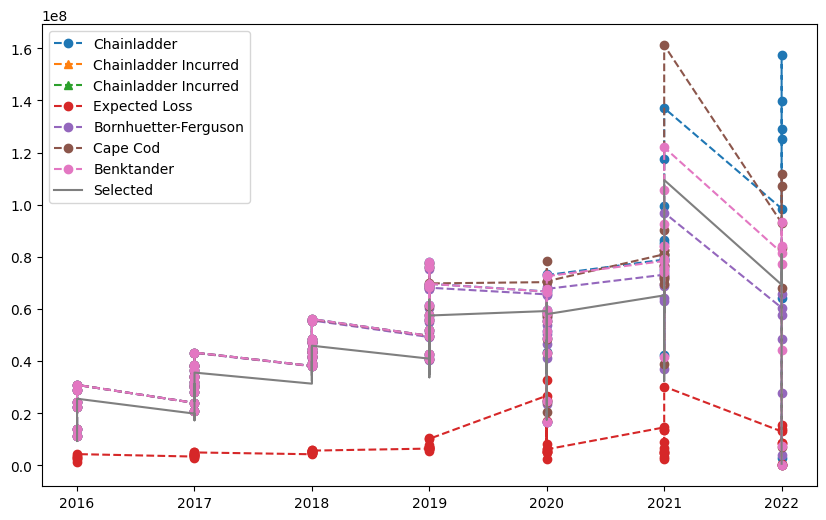

In [70]:

loss_data = IBNR["Paid_Claim"].sum()
loss_data2=pure["Claim_Estimate"].sum()
loss_data3=IBNER["Claim_Estimate"].sum()
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(
cl_mod.fit(loss_data).ultimate_.to_frame().index.year,
cl_mod.fit(loss_data).ultimate_.to_frame(),
label="Chainladder",
linestyle="dashed",
marker="o",
)
plt.plot(cl_mod.fit(loss_data2).ultimate_.to_frame().index.year,
         cl_mod.fit(pure["Claim_Estimate"].sum()).ultimate_.to_frame() - cl_mod.fit(pure["Claim_Estimate"].sum()).latest_diagonal.to_frame() + 
         cl_mod.fit(IBNER["Paid_Claim"].sum()).ultimate_.to_frame()-cl_mod.fit(IBNER["Paid_Claim"].sum()).latest_diagonal.to_frame(),
         label = "Chainladder Incurred",
         linestyle = "dashed",
         marker = "^",)
'''plt.plot(cl_mod.fit(loss_data3).ultimate_.to_frame().index.year,
         cl_mod.fit(loss_data3).ultimate_.to_frame(),
         label = "Chainladder Incurred",
         linestyle = "dashed",
         marker = "+",)'''
plt.plot(
el_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame().index.year,
el_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame(),
label="Expected Loss",
linestyle="dashed",marker="o",
)
plt.plot(
bf_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame().index.year,
bf_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame(),
label="Bornhuetter-Ferguson",
linestyle="dashed",
marker="o",
)
plt.plot(
cc_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame().index.year,
cc_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame(),
label="Cape Cod",
linestyle="dashed",
marker="o",
)
plt.plot(
bk_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame().index.year,
bk_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame(),
label="Benktander",
linestyle="dashed",
marker="o",
)
plt.plot(
vot_mod.ultimate_.to_frame().index.year,
vot_mod.ultimate_.to_frame(),
label="Selected",
)
plt.legend(loc="best")

In [ ]:
#MackChainladder : Schochastic claim Reserving Model for Development Factors


In [71]:
plt.bar(
mack_mod.summary_.to_frame().index.year,
mack_mod.summary_.to_frame()["Latest"],
label="Paid",
)
plt.bar(
mack_mod.summary_.to_frame().index.year,
mack_mod.summary_.to_frame()["IBNR"],
bottom=mack_mod.summary_.to_frame()["Latest"],
yerr=mack_mod.summary_.to_frame()["Mack Std Err"],
label="Unpaid",
)
plt.legend(loc="upper left")
plt.ylim(0, 20000000)

NameError: name 'mack_mod' is not defined

In [340]:
#Testing Results
errors = cl_mod.full_expectation_ - cl_mod.full_triangle_
errors[errors.valuation < IBNR.valuation_date]

#With this, we can also force the IBNR run-off of future periods, let’s say we want the next three years’.
cl_mod.full_triangle_.dev_to_val().cum_to_incr().loc[..., "2023":"2028"]

,2023,2024,2025,2026,2027,2028
2016,,,,,,
2017,"487,647",,,,,
2018,"1,962,410","683,269",,,,
2019,"4,130,382","2,572,568","895,712",,,
2020,"9,336,385","3,589,957","2,235,969","778,516",,
2021,"64,010,678","13,662,653","5,253,462","3,272,067","1,139,263",
2022,"252,614,385","37,224,487","7,945,319","3,055,075","1,902,823","662,522"


In [341]:
IBNR["Premium"].sum()

,12,24,36,48,60,72,84
2016,"22,704,590","44,183,597","47,020,196","47,469,445","47,613,584","47,671,047","47,784,861"
2017,"37,881,066","64,931,531","66,590,414","67,439,303","67,611,513","68,342,983",
2018,"54,340,061","84,289,655","87,859,708","88,910,119","90,625,396",,
2019,"71,434,700","116,284,684","122,716,816","124,718,460",,,
2020,"44,994,807","199,826,761","207,070,559",,,,
2021,"89,453,028","161,246,808",,,,,
2022,"85,865,999",,,,,,


,2261
2016,"38,227,889"
2017,"54,674,386"
2018,"72,500,317"
2019,"99,774,768"
2020,"165,656,447"
2021,"128,997,446"
2022,"68,692,799"


In [296]:
cl.options.get_option("ULT_VAL")

'2261-12-31 23:59:59.999999999'

In [280]:
cl.Development().fit(IBNR["Paid_Claim"].sum()).ldf_

,12-24,24-36,36-48,48-60,60-72,72-84
(All),2.1141,1.0777,1.0154,1.0058,1.0036,1.0013
